In [9]:
# Forked and modified from https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

from __future__ import (absolute_import, division, print_function)

import collections
import math
import os
import random
import zipfile
import re
import time

import pandas
import nltk

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Done")

Done


In [10]:
#TODO(remove other errors, spelling mistakes, urls etc.)
#Pipes and stars.
#TODO Preprocessing and cleaning of text data
# Split concatenated words http://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
def get_full_text_description(data_column):
  pattern = re.compile(r'(\w+)\/(\w+)')
  cleaned_text = ''  
  for cell in data_column:
    if pattern.search(cell):
      cell = pattern.sub(r'\1 \2', cell)
    cleaned_text += cell.lower() + ' '
  tokens = nltk.word_tokenize(cleaned_text)
  text = nltk.Text(tokens)
  return text

In [11]:
data = pandas.read_csv('data/train.csv', nrows=25000) #Can read a subset. First nrows of the total.
words = get_full_text_description(data['FullDescriptionWithTitle'])
print(words[0:100])

['engineering', 'systems', 'analyst', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'our', 'client', 'is', 'located', 'in', 'dorking', ',', 'surrey', 'and', 'are', 'looking', 'for', 'engineering', 'systems', 'analyst', 'our', 'client', 'provides', 'specialist', 'software', 'development', 'keywords', 'mathematical', 'modelling', ',', 'risk', 'analysis', ',', 'system', 'modelling', ',', 'optimisation', ',', 'miser', ',', 'pioneeer', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'engineering', 'systems', 'analyst', 'mathematical', 'modeller', 'engineering', 'systems', 'analyst', '/', 'mathematical', 'modeller', '.', 'our', 'client', 'is', 'a', 'highly', 'successful', 'and', 'respected', 'consultancy', 'providing', 'specialist', 'software', 'development', 'miser', ',', 'pioneer', ',', 'maths', ',', 'mathematical', ',', 'optimisation', ',', 'risk', 'analysis', ',', 'asset', 'management', ',', 'water', 'industry', ',', 'access', '

In [12]:
total_unique_words = len(set(words)) 
print("Total unique words = %s" % total_unique_words)

Total unique words = 62803


In [13]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  word_counter = collections.Counter(words).most_common(vocabulary_size - 1)
  count.extend(word_counter)
  dictionary = dict()
  for word, _ in count:
    # Indexing words by their rank in terms of frequency.
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  count[0] = (count[0][0], count[0][1])
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory requirements.

In [14]:
print('Most common words (+UNK)', count[:25])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
#Generate metadata tsv that maps words to counts. Used for tensorboard.
metadata = pandas.DataFrame(count, columns=["Word", "Frequency"])
print(metadata)
metadata.to_csv("data/word_frequency.tsv", sep="\t", index=False)
#TODO Finish setting up metadata with model.

Most common words (+UNK) [('UNK', 12804), ('and', 258768), (',', 221348), ('.', 206808), ('the', 202588), ('to', 200183), ('a', 146578), ('of', 139207), ('in', 102569), ('for', 86531), ('with', 71266), ('you', 66119), ('will', 63509), ('be', 61857), ('is', 59228), ('****', 52728), ('this', 44814), ('as', 43750), ('are', 42709), ('an', 42398), (':', 42258), ('experience', 41598), ('on', 39361), ('have', 35516), ('or', 32640)]
Sample data [136, 118, 262, 136, 118, 262, 7390, 1000, 79, 179] ['engineering', 'systems', 'analyst', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k']
                                       Word  Frequency
0                                       UNK      12804
1                                       and     258768
2                                         ,     221348
3                                         .     206808
4                                       the     202588
5                                        to     200183
6      

In [15]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

118 systems -> 262 analyst
118 systems -> 136 engineering
262 analyst -> 136 engineering
262 analyst -> 118 systems
136 engineering -> 118 systems
136 engineering -> 262 analyst
118 systems -> 262 analyst
118 systems -> 136 engineering


In [8]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 256  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequently occuring words.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 1.0

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='word_embedding')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, 
                     num_sampled, vocabulary_size))

  optimizer = (
    tf.train.GradientDescentOptimizer(learning_rate).minimize(loss))

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
  # Summary statistic written out for tensorboard.
  tf.summary.scalar('train_loss', loss)

In [25]:

# Step 5: Begin training.
num_steps = 1000

evaluation_interval_size = 1000

log_dir = "logs/word2vec"

# Note that this is expensive (~20% slowdown if computed every 500 steps)
printout_frequency = 100000

checkpoint_frequency = 25000
#TODO(max): Remove this 
checkpoint_folder = logs_dir

average_loss = 0

ckpt = tf.train.get_checkpoint_state(checkpoint_folder)                                     

if ckpt:
    restore_from_model = True
else:
    restore_from_model = False

with tf.Session(graph=graph) as session:
  summaries = tf.summary.merge_all()                                                       
  writer = tf.summary.FileWriter(                                                          
      os.path.join(log_dir, time.strftime("%Y-%m-%d-%H-%M-%S")))                  
  writer.add_graph(session.graph)                                                             
                                                                                                  
  session.run(tf.global_variables_initializer())
  saver = tf.train.Saver(tf.global_variables()) 

  if restore_from_model:
    saver.restore(session, ckpt.model_checkpoint_path)

  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs,
                 train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, train_loss = session.run([optimizer, loss], feed_dict=feed_dict)
    
    summ, _, train_loss = session.run([summaries, optimizer, loss], feed_dict=feed_dict)

    writer.add_summary(summ, step)
    writer.flush()

    average_loss += train_loss

    if step % evaluation_interval_size == 0:
      if step > 0:
        average_loss /= evaluation_interval_size
      # The average loss is an estimate of the loss over the last n batches.
      print("Step %s: Loss %s" % (step, average_loss))
      average_loss = 0

    if step % printout_frequency == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to '%s':" % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s '%s'," % (log_str, close_word)
        print(log_str)
    
    if (step + 1) % checkpoint_frequency == 0:
        print("Saving at step: %s" % step)
        checkpoint_path = os.path.join(checkpoint_folder, 'word2vec_model%s.ckpt' % time.strftime("%Y-%m-%d-%H-%M-%S"))                  

        saver.save(session, checkpoint_path, global_step=step)
  final_embeddings = normalized_embeddings.eval()

INFO:tensorflow:Restoring parameters from logs/word2vec/word2vec_model2017-06-05-17-23-38.ckpt-174999
Step 0: Loss 3.81499624252
Nearest to 'we': 'they', 'you', 'i', 'distant', 'sheltered',
Nearest to 'company': 'organisation', 'client', 'brand', 'companies', 'consultancy',
Nearest to 'are': 'is', 'be', ''re', 're', 'have',
Nearest to 'salary': 'package', '****k', 'rate', 'pay', 'basic',
Nearest to 'home': 'role.if', 'homes', 'hotel', 'area', 'facilities',
Nearest to 'management': 'administration', 'managers', 'manager', 'ukthe', 'auditors',
Nearest to 'our': 'my', 'their', 'the', 'its', 'this',
Nearest to 'apply': 'please', 'jonathan', 'considered', '****20', 'marketingled',
Nearest to 'team': 'teams', 'department', 'staff', 'manager', 'role',
Nearest to 'senior': 'experienced', 'junior', 'project', 'team', 'talented',
Nearest to 'good': 'strong', 'excellent', 'great', 'solid', 'proven',
Nearest to 'able': 'ability', 'prepared', 'expected', 'willing', 'eager',
Nearest to '****': '****

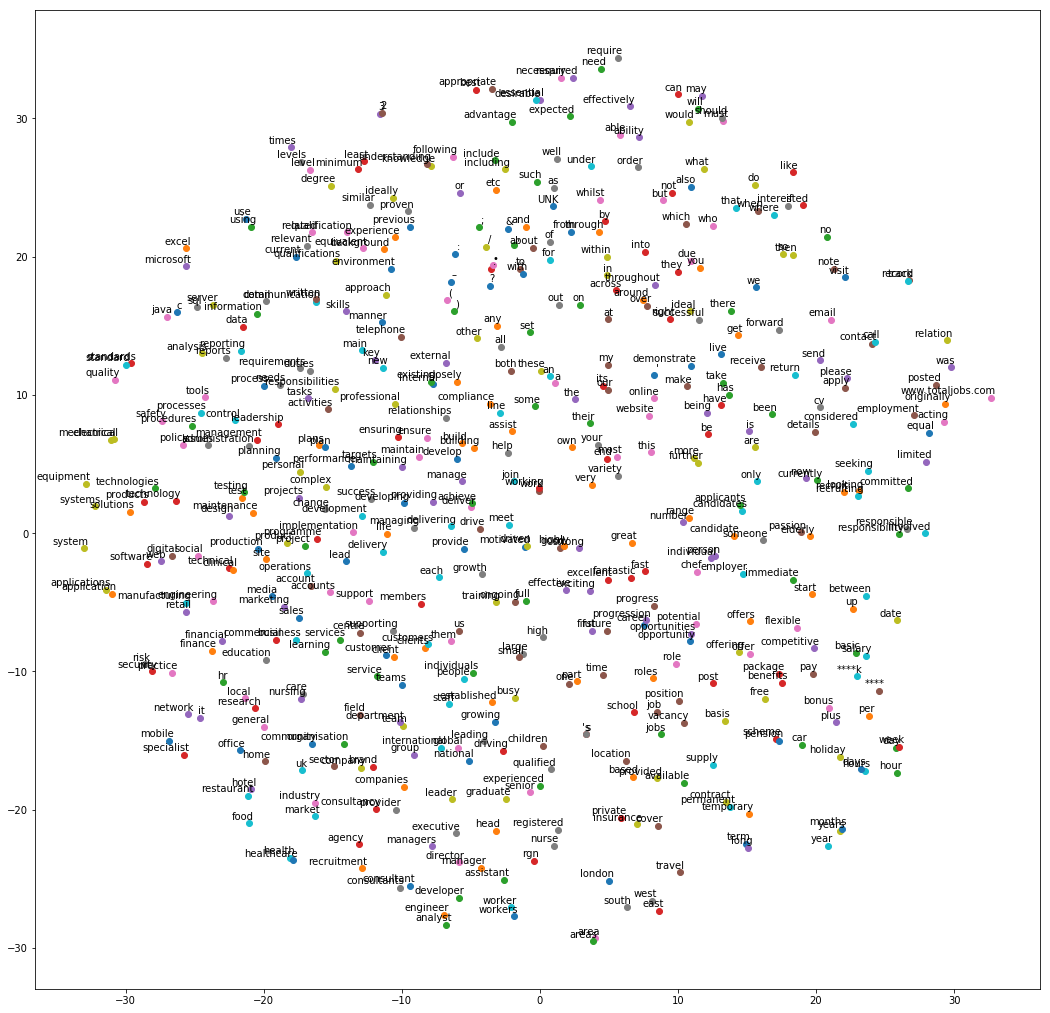

In [26]:
# Step 6: Visualize the embeddings.
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  #plt.show()
  plt.savefig(filename)

try:
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [28]:
print(final_embeddings.shape)
print(labels)
print(final_embeddings)

word2vec = {word: vec for word, vec in zip(labels, final_embeddings)}

(50000, 256)
['UNK', 'and', ',', '.', 'the', 'to', 'a', 'of', 'in', 'for', 'with', 'you', 'will', 'be', 'is', '****', 'this', 'as', 'are', 'an', ':', 'experience', 'on', 'have', 'or', 'work', 'role', 'your', 'team', 'business', 'we', 'manager', ')', 'working', 'skills', 'our', '(', 'all', 'within', 'that', 'sales', 'client', 'their', 'management', 'please', 'at', 'support', 'care', 'company', 'development', 'from', 'looking', 'service', 'excellent', 'required', 'job', 'must', 'if', '/', 'new', 'opportunity', 'recruitment', ';', 'by', 'it', 'apply', 'who', 'successful', 'knowledge', 'uk', 'customer', 'based', 'services', 'not', 'ability', 'home', 'ensure', 'cv', 'training', 'salary', 'environment', 'candidate', 'project', 'they', 'strong', 'good', 'able', 'high', 'including', 'join', 'also', 'clients', 'has', 'technical', 'design', 'position', 'senior', 'well', 'other', 'staff', 'provide', 'engineer', 'full', 'can', 'essential', 'time', 'quality', 'leading', 'would', 'candidates', '&', 

In [38]:
word2vec.get('supply', word2vec['UNK'])

array([-0.04104966,  0.0921788 ,  0.04168205,  0.01599683, -0.05406885,
        0.04988802, -0.06296495, -0.00694938,  0.0383863 , -0.0607474 ,
       -0.03093284, -0.04445867, -0.07753322,  0.05283375,  0.00533725,
       -0.02997736, -0.01902374, -0.03821902, -0.01696371,  0.01461623,
       -0.0097334 , -0.11530091, -0.03578868,  0.01846583,  0.09171358,
       -0.07756132,  0.02030713, -0.07860705, -0.06959038,  0.05060002,
        0.10639673,  0.03821396,  0.02448515,  0.06120142, -0.0956983 ,
        0.12891419, -0.04583335, -0.06532969, -0.02888765, -0.07131202,
       -0.00929034, -0.03070444,  0.05380997, -0.08683397, -0.02393652,
       -0.06579712,  0.03841279,  0.01634257,  0.04423721,  0.07401088,
        0.108969  ,  0.07981069,  0.11048781, -0.02388323,  0.02119473,
       -0.07308035, -0.05237604, -0.03038209,  0.05855969, -0.06771097,
       -0.01961614, -0.00682913, -0.07910853,  0.01183993, -0.03397257,
       -0.07540916,  0.0048745 ,  0.05246614, -0.00251655,  0.07